In [2]:
%matplotlib notebook

from Bio.PDB.PDBParser import PDBParser

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import numpy as np
import pandas as pd
from scipy.spatial import distance
import math

import tensorflow as tf

def average_pos(poss):
    avg_X, avg_Y, avg_Z = zip(*poss)
    avg_X = np.mean(avg_X)
    avg_Y = np.mean(avg_Y)
    avg_Z = np.mean(avg_Z)
    return avg_X, avg_Y, avg_Z

def dot_product(vec1, vec2):
    return sum([float(v1) * float(v2) for v1, v2 in zip(vec1, vec2)])

def vec_len(vec):
    return math.sqrt(float(sum([v * v for v in vec])))

def vec_angle(vec1, vec2):
    if vec1 == vec2:
        return 0.0
    angle = dot_product(vec1, vec2) / (vec_len(vec1) * vec_len(vec2))
    angle = math.degrees(math.acos(angle))
    assert 0.0 <= angle <= 360.0
    return angle

def calc_side_chain_vector(protres_name, protres_atoms, suppress_warnings=False):
    # composed of two vectors
    # 1. from average position of 'N', 'C' and 'O' atoms to 'CA'
    # 2. average vector from 'CA' to all other atoms except ('N', 'C' and 'O')

    # 1.
    avg_backbone = []
    CA_atom_coords = []
    avg_side_chain = []
    for a_id, coords in protres_atoms.items():
        if a_id in ['N', 'C', 'O']:
            if a_id != 'O':
                avg_backbone.append(coords)
        elif a_id == 'CA':
            CA_atom_coords.append(coords)
        else:
            if a_id == 'CB':
                avg_side_chain.append(coords)

    if len(CA_atom_coords) != 1:
        if not suppress_warnings:
            print("Warning, no CA atom in:", protres_name)
        return None, None

    assert len(CA_atom_coords) == 1
    CA_atom_coords = CA_atom_coords[0]
    CA_pos_X, CA_pos_Y, CA_pos_Z = CA_atom_coords
    backbone_X, backbone_Y, backbone_Z = average_pos(avg_backbone)

    vec_1 = (
        CA_pos_X - backbone_X, CA_pos_Y - backbone_Y, CA_pos_Z - backbone_Z)

    if protres_name == 'GLY':
        assert len(avg_side_chain) == 0
        return vec_1, CA_atom_coords
    else:
        assert len(avg_side_chain) > 0

    # 2.
    side_X, side_Y, side_Z = average_pos(avg_side_chain)
    vec_2 = (side_X - CA_pos_X, side_Y - CA_pos_Y, side_Z - CA_pos_Z)

    # angle between the two vectors has to be less than 90
    # A . B = |A| * |B| * cos(angle)
    # cos(angle) = A.B / (|A|*|B|)
    # angle = arccos(A.B / (|A|*|B|))
    # angle_deg = vec_angle(vec_1, vec_2)
    #
    # if angle_deg > 180.0:
    #    angle_deg = angle_deg - 360.0
    # if angle_deg >= 70:
    #    if not suppress_warnings:
    #        print("Warning: high angle (%s) between CA-CB and bacbone-CA vectors in %s" % (angle_deg, protres_name))
    #    return None, None
    #
    # assert angle_deg < 70.0

    # average of the two vectors
    vec = tuple(v1 + v2 for v1, v2 in zip(vec_1, vec_2))

    return vec, CA_atom_coords

def get_protein_and_rna(structure):
    protein = []
    protein_names = []
    rna = []
    rna_names = []
    for model in structure:
        for chain in model:
            for residue in chain:
                res_name = residue.get_resname().strip()
                atoms = {}
                for atom in residue:
                    atoms[atom.id] = atom.get_coord()

                if res_name in ['A', 'C', 'G', 'U']:
                    rna.append(atoms)
                    rna_names.append(res_name)
                elif (res_name in [ 'ALA', 'ARG','ASN','ASP','CYS','GLU','GLN','HIS','ILE','LEU','LYS','MET',
                                 'PHE','PRO','SER','THR','TRP','TYR', 'VAL']
                        and {'CA', 'CB', 'C', 'N'}.issubset(set(atoms.keys()))) or \
                        (res_name == 'GLY' and {'CA', 'C', 'N'}.issubset(set(atoms.keys()))):

                    protein.append(atoms)
                    protein_names.append(res_name)
                else:
                    print(res_name)
    return protein, rna, protein_names, rna_names

def perpendicular_proj(normal, point_plane, point):
    d = np.longdouble((point-point_plane).dot(normal/np.linalg.norm(normal)))
    return np.longdouble(point - d * (normal/np.linalg.norm(normal)))

def transformation_matrix(aminoacid_atoms, aminoacid_name):
    a = aminoacid_atoms['CA']
    b = np.array(calc_side_chain_vector(aminoacid_name, aminoacid_atoms, suppress_warnings=False)[0])
    # b = aminoacid_atoms['CB']
    c1 = aminoacid_atoms['C']
    c2 = aminoacid_atoms['N']
    if (b - a).dot(c2 - c1) == 0:
        c = a + (c2 - c1)
    else:
        c1_p = perpendicular_proj(b - a, a, c1)
        c2_p = perpendicular_proj(b - a, a, c2)
        #print((c1_p - c2_p).dot(b - a))
        c = a + (c2_p - c1_p)

    d = a + np.cross((b - a), (c - a))

    u = ((d - a) / (np.linalg.norm(d - a)))
    v = ((c - a) / np.linalg.norm(c - a))
    w = ((b - a) / np.linalg.norm(b - a))
    u_m = np.append(u, 0)
    v_m = np.append(v, 0)
    w_m = np.append(w, 0)

    m = np.vstack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
    a_t = m.dot(np.append(a, 1))
    m[:, 3] = -a_t

    m2 = np.column_stack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
    m2[:, 3] = np.append(a, 1)

    #angle between b and c1->c2
    angle = (np.arccos((b.dot(c2-c1))/(np.linalg.norm(b) * np.linalg.norm(c2-c1)))) * (180/np.pi)

    return m, m2, angle

def voxelization_4D(atom_corr, atom_names, x_y_z=[10,10,10], xyz_sizes=np.array([13, 13, 6, 5])):

    xyzmin = np.array([-xyz_sizes[0]/2, -xyz_sizes[1]/2, -xyz_sizes[3]]) - np.array([2, 2, 1])
    xyzmax = np.array([xyz_sizes[0]/2, xyz_sizes[1]/2, xyz_sizes[2]]) + np.array([2, 2, 5])



    segments = []
    shape = []

    for i in range(3):
        s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
        segments.append(s)
        shape.append(step)

    n_x = x_y_z[0]
    n_y = x_y_z[1]
    n_z = x_y_z[2]

    structure = np.zeros((len(atom_corr), 3), dtype=int)

    structure[:, 0] = np.searchsorted(segments[0], atom_corr[:, 0]) - 1

    structure[:, 1] = np.searchsorted(segments[1], atom_corr[:, 1]) - 1

    structure[:, 2] = np.searchsorted(segments[2], atom_corr[:, 2]) - 1

    if atom_names is not None:
        vector = np.zeros((n_x, n_y, n_z, 3))
        for name, row in zip(atom_names, structure):
            x, y, z = row
            if 0 <= x < n_x and 0 <= y < n_y and 0 <= z < n_z:
                if 'C' in name:
                    vector[x, y, z, 0] += 1
                if 'O' in name:
                    vector[x, y, z, 1] += 1
                if 'N' in name:
                    vector[x, y, z, 2] += 1

    else:
        vector_p = np.zeros((n_x, n_y, n_z))
        for row in structure:
            x, y, z = row
            if 0 <= x < n_x and 0 <= y < n_y and 0 <= z < n_z:
                vector_p[x, y, z] += 1

        vector = np.sum(np.sum(vector_p, axis=0), axis=0)

    return vector

def voxelization_structure(structure_atoms, rna_atoms, interaction_points, structure_id):
    xyzmax = np.amax(structure_atoms, axis=0) + 0.001
    xyzmin = np.amin(structure_atoms, axis=0) - 0.001
    x_size = xyzmax[0] - xyzmin[0]
    y_size = xyzmax[1] - xyzmin[1]
    z_size = xyzmax[2] - xyzmin[2]

    x_y_z = [int(round(x_size/1.7)), int(round(y_size/1.7)), int(round(z_size/1.7))]

    segments = []
    shape = []

    for i in range(3):
        # note the +1 in num
        # if type(x_y_z[i]) is not int:
        #     raise TypeError("x_y_z[{}] must be int".format(i))
        s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
        segments.append(s)
        shape.append(step)

    n_x = x_y_z[0]
    n_y = x_y_z[1]
    n_z = x_y_z[2]

    structure = np.zeros((len(interaction_points), 3), dtype=int)

    structure[:, 0] = np.searchsorted(segments[0], interaction_points[:, 0]) - 1

    structure[:, 1] = np.searchsorted(segments[1], interaction_points[:, 1]) - 1

    structure[:, 2] = np.searchsorted(segments[2], interaction_points[:, 2]) - 1


    vector = np.zeros((n_x, n_y, n_z))
    for x,y,z in structure:
        #x, y, z = row
        if x >=0 and y >= 0 and z >= 0:
            try:
                vector[x, y, z] += 1
            except:
                # print(x,y,z)
                continue

    facecolors = np.where(vector, '#7A88CCC0', '#FFD65DC0')
    edgecolors = np.where(vector, '#BFAB6E', '#7D84A6')
    filled = np.ones(vector.shape)
    x, y, z = np.meshgrid(segments[1], segments[0], segments[2])

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.voxels(y, x, z, vector, facecolors=facecolors, edgecolors=edgecolors)
    ax.plot(rna_atoms[:, 0], rna_atoms[:, 1], rna_atoms[:, 2], 'ko')

    fig.suptitle(f"Structure  ID: {structure_id}")
    plt.show()
    return vector

def combine_predictions(structure_id):
    parser = PDBParser()
    structure = parser.get_structure(structure_id, '../data/pdb structures/' + 'pdb' + structure_id + '.ent')

    protein, rna, protein_names, rna_names = get_protein_and_rna(structure)

    all_protein_atoms = np.concatenate(list(map(lambda x: list(x.values()), protein)))
    all_protein_1 = np.hstack((all_protein_atoms, np.ones((all_protein_atoms.shape[0], 1))))
    all_protein_atoms_names = np.concatenate(list(map(lambda x: list(x.keys()), protein)))

    all_rna_atoms = np.concatenate(list(map(lambda x: list(x.values()), rna)))
    all_rna_1 = np.hstack((all_rna_atoms, np.ones((all_rna_atoms.shape[0], 1))))
    
    points_interaction = np.empty((0, 3))
    for aminoacid_atoms, aminoacid_name in zip(protein, protein_names):
        m, m2, angle = transformation_matrix(aminoacid_atoms, aminoacid_name)

        all_protein_n = np.round(m.dot(all_protein_1.T).T, 5)[:, :3]

        all_rna_n = np.round(m.dot(all_rna_1.T).T, 5)[:, :3]

        # amino_acid_voxelization = voxelization_4D(all_protein_n, all_protein_atoms_names)
        rna_vector = voxelization_4D(all_rna_n, None)
        rna_vector[rna_vector > 0] = 1

        a = aminoacid_atoms['CA']  # -z = -5 -1 , +z = 6 + 5
        b = np.array(calc_side_chain_vector(aminoacid_name, aminoacid_atoms, suppress_warnings=False)[0])
        direction = (b-a)/np.linalg.norm(b-a)
        voxel_size = 17/10
        first_point = a + (-6 + (voxel_size/2))*direction
        points = [first_point]
        points.extend([first_point + i*voxel_size*direction for i in range(1, 10)])
        points = np.array(points)

        # points_t_first = np.array([0,0,0]) + np.array([0, 0, (- 6 + (voxel_size/2))])
        # points_t = [points_t_first]
        # points_t.extend([points_t_first + np.array([0,0, j*voxel_size]) for j in range(1,10)])
        # point_t_1 = np.hstack((np.array(points_t), np.ones((10,1))))
        # points_2 = m2.dot(point_t_1.T).T
        #
        # print(np.array(points))
        # print(points_2)
        # print()

        points_interaction = np.vstack((points_interaction, points[np.where(rna_vector==1)[0]]))

    voxelization_structure(all_protein_atoms, all_rna_atoms, points_interaction, structure_id)

<IPython.core.display.Javascript object>


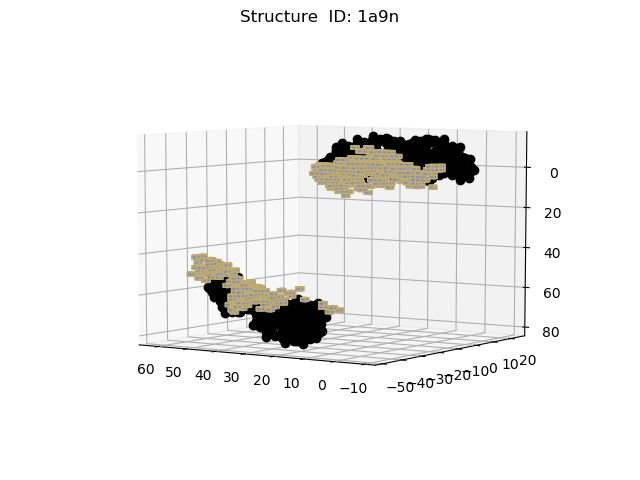

In [2]:
combine_predictions('1a9n')

<IPython.core.display.Javascript object>


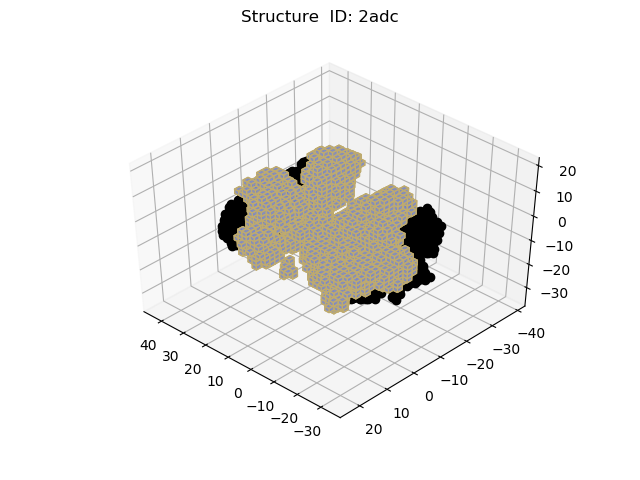

In [3]:
combine_predictions('2adc')